In [17]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from rouge_score import rouge_scorer

In [64]:
from pathlib import Path
import pandas as pd
import numpy as np
from rouge_score import rouge_scorer

path_dfs = Path("/export/data_ml4ds/NextProcurement/pruebas_oct_2025/objective_extractor/results/final/")

# --- ROUGE setup ---
rouge_types = ["rouge1", "rouge2", "rougeL"]
rouge_metrics = ["precision", "recall", "f1"]
keys = ["generative", "extractive"]  # the two objectives to compare against title

def add_rouge_and_lengths(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute:
      • ROUGE(1/2/L) P/R/F1 between title and each *_objective
      • Lengths for each objective: *_len_chars, *_len_words
    """
    # Ensure objective columns exist and are strings
    for k in keys:
        col = f"{k}_objective"
        if col not in df.columns:
            df[col] = ""
        df[col] = df[col].fillna("").astype(str)

    # --- Lengths (vectorized) ---
    for k in keys:
        obj = f"{k}_objective"
        df[f"{k}_len_chars"] = df[obj].str.len()
        # .str.split(None) splits on arbitrary whitespace; .str.len() gives word count
        df[f"{k}_len_words"] = df[obj].str.split().str.len().astype("Int64")

    # --- ROUGE (row-wise) ---
    scorer = rouge_scorer.RougeScorer(rouge_types, use_stemmer=True)
    # Prepare columns
    for k in keys:
        for rt in rouge_types:
            for m in rouge_metrics:
                df[f"{k}_{rt}_{m}"] = np.nan

    # Compute per row
    for idx, row in df.iterrows():
        title = row.get("title", "")
        if not isinstance(title, str):
            title = "" if pd.isna(title) else str(title)

        for k in keys:
            candidate = row[f"{k}_objective"]
            try:
                scores = scorer.score(title, candidate)
            except Exception:
                scores = {rt: rouge_scorer.Score(precision=0.0, recall=0.0, fmeasure=0.0) for rt in rouge_types}

            for rt in rouge_types:
                df.at[idx, f"{k}_{rt}_precision"] = scores[rt].precision
                df.at[idx, f"{k}_{rt}_recall"]    = scores[rt].recall
                df.at[idx, f"{k}_{rt}_f1"]        = scores[rt].fmeasure

    return df

# --- Columns to keep/rename/merge ---
cols_keep = []
for key in ["generative", "extractive"]:
    for type in ["bert", "token"]:
        cols_keep.extend([f'{key}_{type}_precision', f'{key}_{type}_recall', f'{key}_{type}_f1'])
    cols_keep.extend([f"{key}_time_seconds"])

# Add ROUGE columns
for key in keys:
    for rt in rouge_types:
        cols_keep.extend([f"{key}_{rt}_precision", f"{key}_{rt}_recall", f"{key}_{rt}_f1"])

# --- NEW: add length columns ---
for key in keys:
    cols_keep.extend([f"{key}_len_chars", f"{key}_len_words"])

df_final = None

for path_df in path_dfs.iterdir():
    if path_df.suffix == '.parquet':
        df = pd.read_parquet(path_df)

        # Compute ROUGE + length columns
        df = add_rouge_and_lengths(df)

        model_name = path_df.stem.split("parquet_")[-1].split(".parquet")[0]

        # Select and rename columns
        base_cols = ["place_id", "title"]
        existing_cols_keep = [c for c in cols_keep if c in df.columns]  # guard in case some metrics are absent
        df_selected = df[base_cols + existing_cols_keep].copy()

        # Prefix metrics with model name
        rename_dict = {col: f"{model_name}_{col}" for col in existing_cols_keep}
        df_selected.rename(columns=rename_dict, inplace=True)

        # Merge
        if df_final is None:
            df_final = df_selected
        else:
            df_final = df_final.merge(df_selected, on=["place_id", "title"], how="outer")

# --- Summary stats (all numeric columns except keys) ---
numeric_cols = [col for col in df_final.columns if col not in ["place_id", "title"]]
df_stats = df_final[numeric_cols].describe().T


In [66]:
df_stats

,count,mean,std,min,25%,50%,75%,max
qwen3-8b_generative_bert_precision,1000.0,0.837934,0.025603,0.746998,0.822874,0.837622,0.852249,0.948883
qwen3-8b_generative_bert_recall,1000.0,0.890982,0.038737,0.771447,0.863594,0.892392,0.920183,0.974095
qwen3-8b_generative_bert_f1,1000.0,0.863232,0.026273,0.773014,0.846232,0.863332,0.879995,0.945332
qwen3-8b_generative_token_precision,1000.0,0.131961,0.094191,0.0,0.067416,0.107418,0.169492,0.9375
qwen3-8b_generative_token_recall,1000.0,0.520727,0.297936,0.0,0.25,0.5,0.8,1.0
...,...,...,...,...,...,...,...,...
llama3.1-8b_extractive_rougeL_f1,1000.0,0.34057,0.274698,0.0,0.128069,0.25,0.491228,1.0
llama3.1-8b_generative_len_chars,1000.0,611.393,288.559646,51.0,401.75,579.0,744.0,2344.0
llama3.1-8b_generative_len_words,1000.0,92.08,43.932535,9.0,61.0,86.0,112.25,349.0
llama3.1-8b_extractive_len_chars,1000.0,1194.844,17186.516113,1.0,104.75,172.0,293.5,320951.0


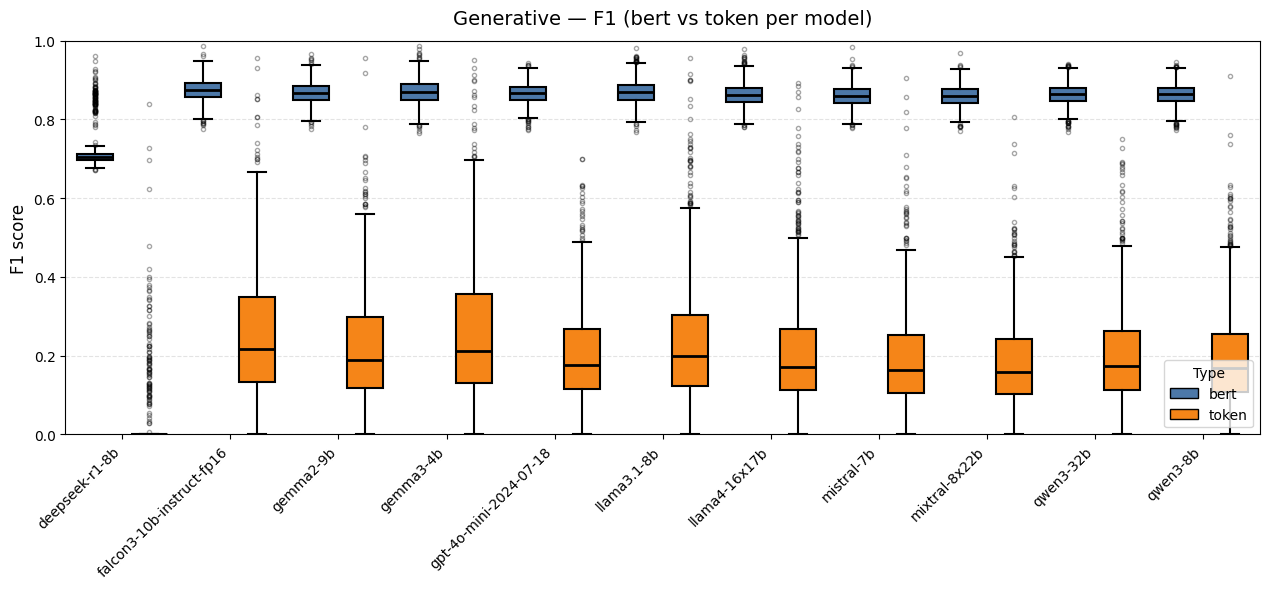

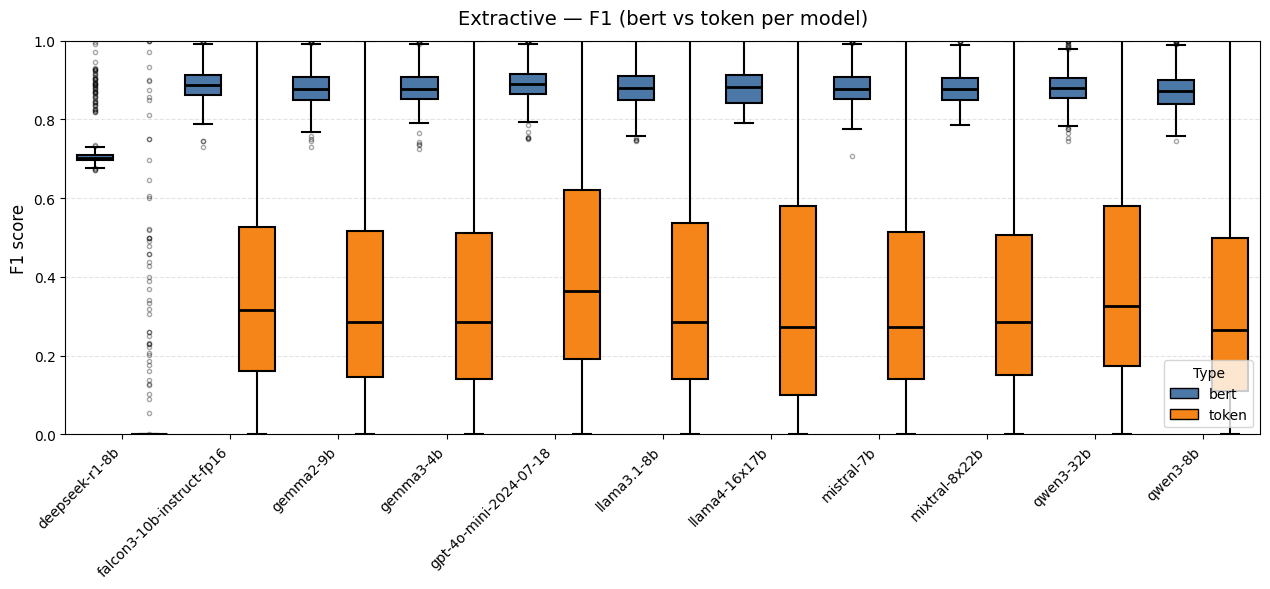

In [67]:
def parse_col(col):
    # Split only at the first underscore before the key (generative/extractive)
    m = re.search(r"_(generative|extractive)_", col)
    if not m:
        return None
    key = m.group(1)
    model = col[:m.start()]
    rest = col[m.end():]  # e.g., "bert_f1"
    type_, metric = rest.split("_", 1)  # ("bert", "f1")
    return model, key, type_, metric

# Identify all f1 columns to keep the plot readable (two boxes per model: bert_f1 and token_f1)
parsed = []
for c in df_final.columns:
    if c in ("place_id", "title"):
        continue
    info = parse_col(c)
    if info is None:  # skip unexpected columns
        continue
    model, key, type_, metric = info
    if metric == "f1" and type_ in ("bert", "token"):
        parsed.append((c, model, key, type_))

# Build long-form frames for generative and extractive (F1 only)
def build_long_for_key(target_key):
    rows = []
    for c, model, key, type_ in parsed:
        if key != target_key:
            continue
        # Collect values (dropna)
        vals = df_final[c].dropna().values
        for v in vals:
            rows.append({"model": model, "type": type_, "value": v})
    return pd.DataFrame(rows)

df_gen = build_long_for_key("generative")
df_ext = build_long_for_key("extractive")

# If either is empty, alert
if df_gen.empty:
    raise RuntimeError("No generative F1 data found among the parquet files.")
if df_ext.empty:
    raise RuntimeError("No extractive F1 data found among the parquet files.")

# Create a wide table where each column is a (model|type) pair
def to_wide(df_long):
    wide_cols = {}
    for (model, type_), sub in df_long.groupby(["model", "type"])["value"]:
        wide_cols[f"{model}|{type_}"] = pd.Series(sub.values)
    wide_df = pd.DataFrame(wide_cols)
    return wide_df

wide_gen = to_wide(df_gen)
wide_ext = to_wide(df_ext)

def _sorted_models(wide_df):
    return sorted({c.split("|")[0] for c in wide_df.columns})

def _grouped_boxplot(wide_df, title, ylabel, bert_color="#4C78A8", token_color="#F58518", ylimit=(0, 1)):
    models = _sorted_models(wide_df)

    # Prepare data arrays in order: [bert, token] per model
    data = []
    positions = []
    tick_positions = []
    tick_labels = []

    group_gap = 0.8          # space between model groups
    box_sep = 0.45           # half-distance between the two boxes within a group
    box_width = 0.6
    pos = 1.0

    for m in models:
        s_bert = wide_df.get(f"{m}|bert", pd.Series(dtype=float)).dropna().values
        s_token = wide_df.get(f"{m}|token", pd.Series(dtype=float)).dropna().values

        data.extend([s_bert, s_token])
        positions.extend([pos - box_sep, pos + box_sep])
        tick_positions.append(pos)
        tick_labels.append(m)
        pos += 1.0 + group_gap

    fig = plt.figure(figsize=(max(10, 0.8 * len(models) + 4), 6))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=box_width,
        patch_artist=True,      # allow facecolors
        showmeans=False,
        whis=1.5,
        medianprops=dict(linewidth=2, color="black"),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5),
        boxprops=dict(linewidth=1.5),
        flierprops=dict(marker="o", markersize=3, alpha=0.35),
    )

    # Color alternate boxes: evens=bert, odds=token
    for i, box in enumerate(bp["boxes"]):
        box.set_facecolor(bert_color if i % 2 == 0 else token_color)

    # Styling
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.35)
    if ylimit:
        ax.set_ylim(*ylimit)

    # Legend
    legend_handles = [
        Patch(facecolor=bert_color, edgecolor="black", label="bert"),
        Patch(facecolor=token_color, edgecolor="black", label="token"),
    ]
    ax.legend(handles=legend_handles, title="Type", loc="lower right", frameon=True)

    fig.tight_layout()
    plt.show()

_grouped_boxplot(wide_gen, "Generative — F1 (bert vs token per model)", "F1 score")
_grouped_boxplot(wide_ext, "Extractive — F1 (bert vs token per model)", "F1 score")

/tmp/ipykernel_1387769/1397475711.py:243: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.98])


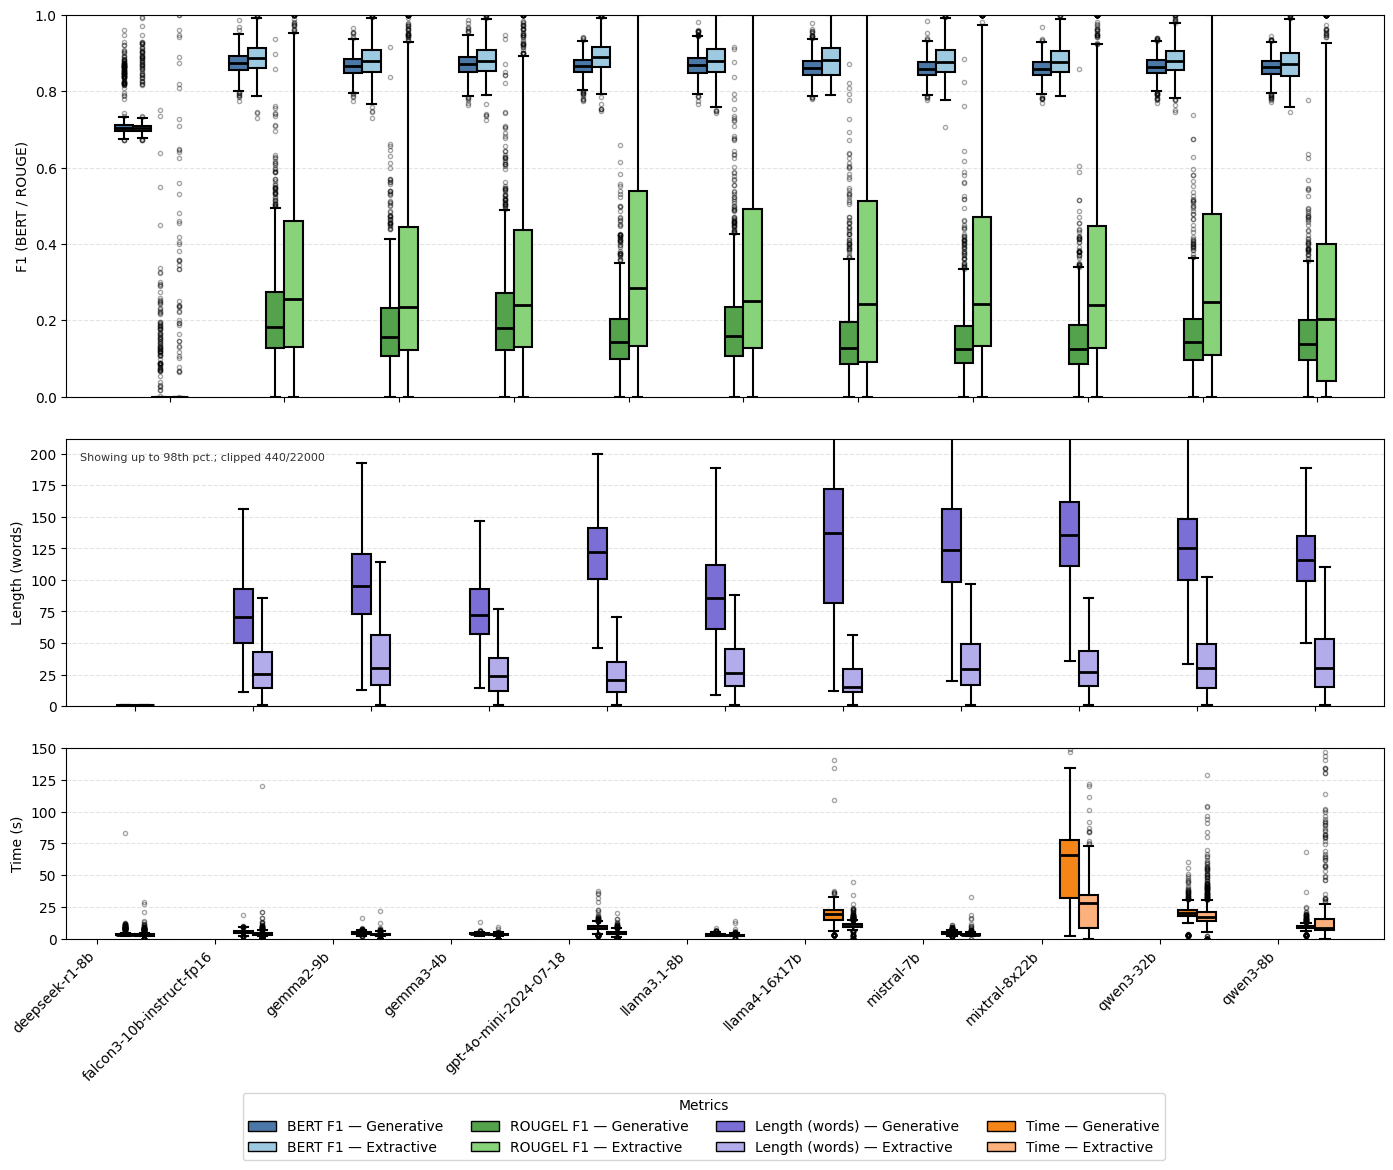

In [76]:
# --- CONFIG ---
MANUAL_TIME_CAP   = 150
USE_LOG_TIME      = False
TIME_QUANTILE     = 0.98

# Which ROUGE to show on the plot: "rouge1" | "rouge2" | "rougeL"
ROUGE_TYPE = "rougeL"

# Which length to display: "words" | "chars"
LENGTH_KIND = "words"

# Layout: "stacked3" (F1 + Length + Time) | "stacked" (F1 + Time) | "single" (F1+Time one panel)
LAYOUT = "stacked3"

# --- NEW length-visibility controls ---
USE_LOG_LENGTH      = False         # True => log scale for length
LENGTH_CAP          = None          # e.g., 500 or None to auto by quantile
LENGTH_QUANTILE     = 0.98          # used when LENGTH_CAP is None
LENGTH_HIDE_FLIERS  = True          # hide length fliers so boxes are clear
SHOW_CLIP_NOTE      = True          # show a note with how many points were clipped

# Colors
COL_F1_GEN = "#4C78A8"  # BERT F1 — Generative
COL_F1_EXT = "#9ecae1"  # BERT F1 — Extractive
COL_R_GEN  = "#54a24b"  # ROUGE F1 — Generative
COL_R_EXT  = "#88d27a"  # ROUGE F1 — Extractive
COL_T_GEN  = "#F58518"  # Time — Generative
COL_T_EXT  = "#fcb07c"  # Time — Extractive
COL_L_GEN  = "#7b6fd6"  # Length — Generative
COL_L_EXT  = "#b3aceb"  # Length — Extractive

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- Regex patterns (BERT/ROUGE/Time/Length) ---
score_pat_bert  = re.compile(
    r"^(?P<model>.+)_(?P<key>generative|extractive)_(?P<type>bert)_(?P<metric>precision|recall|f1)$"
)
score_pat_rouge = re.compile(
    r"^(?P<model>.+)_(?P<key>generative|extractive)_(?P<rtype>rouge1|rouge2|rougeL)_(?P<metric>precision|recall|f1)$"
)
time_pat  = re.compile(r"^(?P<model>.+)_(?P<key>generative|extractive)_time_seconds$")
length_pat = re.compile(
    r"^(?P<model>.+)_(?P<key>generative|extractive)_len_(?P<kind>words|chars)$"
)

def collect_cols(df):
    bert_scores, rouge_scores, times, lengths = [], [], [], []
    for c in df.columns:
        if c in ("place_id", "title"):
            continue
        m = score_pat_bert.match(c)
        if m:
            bert_scores.append((c, m["model"], m["key"], "bert", m["metric"]))
            continue
        m = score_pat_rouge.match(c)
        if m:
            rouge_scores.append((c, m["model"], m["key"], m["rtype"], m["metric"]))
            continue
        m = time_pat.match(c)
        if m:
            times.append((c, m["model"], m["key"]))
            continue
        m = length_pat.match(c)
        if m:
            lengths.append((c, m["model"], m["key"], m["kind"]))
    return bert_scores, rouge_scores, times, lengths

bert_scores, rouge_scores, times, lengths = collect_cols(df_final)

def build_long(df, which_key, rouge_type="rougeL", length_kind="words"):
    rows_f1_bert = [
        {"model": model, "value": v}
        for c, model, key, _, metric in bert_scores
        if key == which_key and metric == "f1"
        for v in df[c].dropna().values
    ]
    rows_f1_rouge = [
        {"model": model, "value": v}
        for c, model, key, rtype, metric in rouge_scores
        if key == which_key and rtype == rouge_type and metric == "f1"
        for v in df[c].dropna().values
    ]
    rows_time = [
        {"model": model, "value": v}
        for c, model, key in times
        if key == which_key
        for v in df[c].dropna().values
    ]
    rows_len = [
        {"model": model, "value": v}
        for c, model, key, kind in lengths
        if key == which_key and kind == length_kind
        for v in df[c].dropna().values
    ]
    return (pd.DataFrame(rows_f1_bert), pd.DataFrame(rows_f1_rouge),
            pd.DataFrame(rows_time), pd.DataFrame(rows_len))

df_gen_f1b, df_gen_f1r, df_gen_time, df_gen_len = build_long(df_final, "generative", ROUGE_TYPE, LENGTH_KIND)
df_ext_f1b, df_ext_f1r, df_ext_time, df_ext_len = build_long(df_final, "extractive", ROUGE_TYPE, LENGTH_KIND)

def to_wide(df_long):
    wide = {}
    for model, sub in df_long.groupby("model")["value"]:
        wide[model] = pd.Series(sub.values)
    return pd.DataFrame(wide)

gen_f1b_w = to_wide(df_gen_f1b); ext_f1b_w = to_wide(df_ext_f1b)
gen_f1r_w = to_wide(df_gen_f1r); ext_f1r_w = to_wide(df_ext_f1r)
gen_times_w  = to_wide(df_gen_time); ext_times_w  = to_wide(df_ext_time)
gen_len_w    = to_wide(df_gen_len);  ext_len_w    = to_wide(df_ext_len)

models = sorted(
    set(gen_f1b_w.columns) & set(ext_f1b_w.columns) &
    set(gen_f1r_w.columns) & set(ext_f1r_w.columns) &
    set(gen_times_w.columns) & set(ext_times_w.columns) &
    set(gen_len_w.columns) & set(ext_len_w.columns)
)
if not models:
    raise RuntimeError("No common models found across all metrics (incl. lengths).")

# Align
gen_f1b_w = gen_f1b_w.reindex(columns=models); ext_f1b_w = ext_f1b_w.reindex(columns=models)
gen_f1r_w = gen_f1r_w.reindex(columns=models); ext_f1r_w = ext_f1r_w.reindex(columns=models)
gen_times_w = gen_times_w.reindex(columns=models); ext_times_w = ext_times_w.reindex(columns=models)
gen_len_w   = gen_len_w.reindex(columns=models);   ext_len_w   = ext_len_w.reindex(columns=models)

def _box(ax, data_list, positions, facecolor, showfliers=True):
    bp = ax.boxplot(
        data_list, positions=positions, widths=0.16, patch_artist=True,
        medianprops=dict(linewidth=2, color="black"),
        whiskerprops=dict(linewidth=1.5), capprops=dict(linewidth=1.5),
        boxprops=dict(linewidth=1.5),
        flierprops=dict(marker="o", markersize=3, alpha=0.35),
        showfliers=showfliers
    )
    for b in bp["boxes"]:
        b.set_facecolor(facecolor)

def combined_with_rouge_and_length(
    gen_f1b, ext_f1b, gen_f1r, ext_f1r, gen_times, ext_times, gen_len, ext_len, models, title
):
    centers = list(range(1, len(models) + 1))
    w = 0.16

    # Positions
    pos_f1b_gen = [c - 5*w/2 for c in centers]
    pos_f1b_ext = [c - 3*w/2 for c in centers]
    pos_r_gen   = [c -   w/2 for c in centers]
    pos_r_ext   = [c +   w/2 for c in centers]
    pos_len_gen = [c - w/2 for c in centers]
    pos_len_ext = [c + w/2 for c in centers]
    pos_t_gen   = [c + 3*w/2 for c in centers]
    pos_t_ext   = [c + 5*w/2 for c in centers]

    # Data
    data_f1b_gen = [gen_f1b[m].dropna().values for m in models]
    data_f1b_ext = [ext_f1b[m].dropna().values for m in models]
    data_r_gen   = [gen_f1r[m].dropna().values for m in models]
    data_r_ext   = [ext_f1r[m].dropna().values for m in models]
    data_len_gen = [gen_len[m].dropna().values   for m in models]
    data_len_ext = [ext_len[m].dropna().values   for m in models]
    data_t_gen   = [gen_times[m].dropna().values for m in models]
    data_t_ext   = [ext_times[m].dropna().values for m in models]

    # Shared legend
    legend_handles = [
        Patch(facecolor=COL_F1_GEN, edgecolor="black", label="BERT F1 — Generative"),
        Patch(facecolor=COL_F1_EXT, edgecolor="black", label="BERT F1 — Extractive"),
        Patch(facecolor=COL_R_GEN,  edgecolor="black", label=f"{ROUGE_TYPE.upper()} F1 — Generative"),
        Patch(facecolor=COL_R_EXT,  edgecolor="black", label=f"{ROUGE_TYPE.upper()} F1 — Extractive"),
        Patch(facecolor=COL_L_GEN,  edgecolor="black", label=f"Length ({LENGTH_KIND}) — Generative"),
        Patch(facecolor=COL_L_EXT,  edgecolor="black", label=f"Length ({LENGTH_KIND}) — Extractive"),
        Patch(facecolor=COL_T_GEN,  edgecolor="black", label="Time — Generative"),
        Patch(facecolor=COL_T_EXT,  edgecolor="black", label="Time — Extractive"),
    ]

    # Helper: compute length axis scaling and clip note
    def _set_len_axis(ax_len):
        all_len = pd.concat([gen_len.stack(), ext_len.stack()], axis=0).astype(float)
        upper = LENGTH_CAP if LENGTH_CAP is not None else float(all_len.quantile(LENGTH_QUANTILE))
        if USE_LOG_LENGTH:
            ax_len.set_yscale("log")
            # avoid zero/negatives on log
            ymin = max(1e-6, float(all_len[all_len > 0].min()) if (all_len > 0).any() else 1e-6)
            ax_len.set_ylim(ymin, upper)
        else:
            ax_len.set_ylim(0, upper)

        if SHOW_CLIP_NOTE:
            total = int(all_len.count())
            clipped = int((all_len > upper).sum()) if not USE_LOG_LENGTH else 0  # log doesn't clip by ylim
            if LENGTH_CAP is None:
                note = f"Showing up to {int(LENGTH_QUANTILE*100)}th pct.; clipped {clipped}/{total}"
            else:
                note = f"Capped at {upper:g}; clipped {clipped}/{total}"
            ax_len.text(0.01, 0.95, note, transform=ax_len.transAxes, ha="left", va="top", fontsize=8, alpha=0.8)

    # --- stacked3: F1 + Length + Time (recommended for visibility) ---
    if LAYOUT == "stacked3":
        fig = plt.figure(figsize=(max(12, 1.0 * len(models) + 6), 12))
        gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2, 1.4, 1], hspace=0.15)
        ax_f1  = fig.add_subplot(gs[0, 0])
        ax_len = fig.add_subplot(gs[1, 0])
        ax_t   = fig.add_subplot(gs[2, 0])

        # F1
        _box(ax_f1, data_f1b_gen, pos_f1b_gen, COL_F1_GEN)
        _box(ax_f1, data_f1b_ext, pos_f1b_ext, COL_F1_EXT)
        _box(ax_f1, data_r_gen,   pos_r_gen,   COL_R_GEN)
        _box(ax_f1, data_r_ext,   pos_r_ext,   COL_R_EXT)
        ax_f1.set_title(title, fontsize=14, pad=10)
        ax_f1.set_ylabel("F1 (BERT / ROUGE)")
        ax_f1.set_ylim(0, 1); ax_f1.grid(axis="y", linestyle="--", alpha=0.35)
        ax_f1.set_xticks(centers); ax_f1.set_xticklabels([])

        # Length (with better scaling)
        _box(ax_len, data_len_gen, pos_len_gen, COL_L_GEN, showfliers=not LENGTH_HIDE_FLIERS)
        _box(ax_len, data_len_ext, pos_len_ext, COL_L_EXT, showfliers=not LENGTH_HIDE_FLIERS)
        ax_len.set_ylabel(f"Length ({LENGTH_KIND})")
        ax_len.grid(axis="y", linestyle="--", alpha=0.35)
        ax_len.set_xticks(centers); ax_len.set_xticklabels([])
        _set_len_axis(ax_len)

        # Time
        _box(ax_t, data_t_gen, pos_t_gen, COL_T_GEN)
        _box(ax_t, data_t_ext, pos_t_ext, COL_T_EXT)
        ax_t.set_ylabel("Time (s)")
        ax_t.set_xticks(centers); ax_t.set_xticklabels(models, rotation=45, ha="right")
        if USE_LOG_TIME: ax_t.set_yscale("log")
        if MANUAL_TIME_CAP is not None:
            ax_t.set_ylim(0, MANUAL_TIME_CAP)
        else:
            upper = float(pd.concat([gen_times.stack(), ext_times.stack()]).quantile(TIME_QUANTILE))
            ax_t.set_ylim(0, upper)
        ax_t.grid(axis="y", linestyle="--", alpha=0.35)

        fig.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5, -0.08),
                   ncol=4, frameon=True, title="Metrics")
        fig.tight_layout(rect=[0, 0.05, 1, 0.98])
        plt.show()
        return

    raise ValueError("For best length visibility, use LAYOUT='stacked3'.")

combined_with_rouge_and_length(
    gen_f1b_w, ext_f1b_w, gen_f1r_w, ext_f1r_w,
    gen_times_w, ext_times_w,
    gen_len_w, ext_len_w,
    models,
    title="",
)


In [77]:
LENGTH_KIND = "words"   # "words" or "chars"

def _length_series(s: pd.Series, kind: str) -> pd.Series:
    s = s.fillna("").astype(str)
    if kind == "chars":
        return s.str.len()
    # default words
    return s.str.split().str.len()

rows = []
for path_df in path_dfs.iterdir():
    if path_df.suffix != ".parquet":
        continue
    df = pd.read_parquet(path_df)

    model_name = path_df.stem.split("parquet_")[-1].split(".parquet")[0]

    for col in ["place_id", "title", "generative_objective", "extractive_objective"]:
        if col not in df.columns:
            if col in ("generative_objective", "extractive_objective"):
                df[col] = ""
            else:
                raise KeyError(f"Missing required column '{col}' in {path_df.name}")

    sub = df[["place_id", "title", "generative_objective", "extractive_objective"]].copy()

    sub["generative_len"] = _length_series(sub["generative_objective"], LENGTH_KIND)
    sub["extractive_len"] = _length_series(sub["extractive_objective"], LENGTH_KIND)

    sub["model"] = model_name

    rows.append(sub)

if not rows:
    raise RuntimeError("No parquet files found (or none contained the required columns).")

df_objectives = pd.concat(rows, ignore_index=True)

avg_len = df_objectives.groupby("place_id", as_index=False).agg(
    gen_avg_len=("generative_len", "mean"),
    ext_avg_len=("extractive_len", "mean"),
)

df_objectives = df_objectives.merge(avg_len, on="place_id", how="left")

# Flags: strictly shorter than the average of *its kind* for that place_id
df_objectives["is_gen_below_avg"] = df_objectives["generative_len"] < df_objectives["gen_avg_len"]
df_objectives["is_ext_below_avg"] = df_objectives["extractive_len"] < df_objectives["ext_avg_len"]

# Keep rows where at least one of the kinds is below its per-place average
df_below_any = df_objectives[df_objectives["is_gen_below_avg"] | df_objectives["is_ext_below_avg"]].copy()

# If you prefer to split by kind:
df_below_gen = df_objectives[df_objectives["is_gen_below_avg"]].copy()
df_below_ext = df_objectives[df_objectives["is_ext_below_avg"]].copy()

# Nice, compact columns to inspect
cols_show = [
    "place_id", "title", "model",
    "generative_objective", "generative_len", "gen_avg_len", "is_gen_below_avg",
    "extractive_objective", "extractive_len", "ext_avg_len", "is_ext_below_avg",
]
df_objectives_show = df_objectives[cols_show].sort_values(["place_id", "model"])



# -------- results --------
# df_objectives_show : full table with objectives, lengths, per-place averages, and below-avg flags
# df_below_any       : only rows where either kind is below its per-place average
# df_below_gen       : only rows where generative is below its per-place average
# df_below_ext       : only rows where extractive is below its per-place average


In [78]:
df_below_gen

,place_id,title,generative_objective,extractive_objective,generative_len,extractive_len,model,gen_avg_len,ext_avg_len,is_gen_below_avg,is_ext_below_avg
1,https://contrataciondelestado.es/sindicacion/l...,Acuerdo Marco Suministro de frutas y verduras ...,El objetivo es el suministro de frutas y verdu...,SUMINISTRO DE FRUTAS Y VERDURAS FRESCAS CON DE...,72,19,qwen3-8b,99.636364,18.909091,True,False
6,https://contrataciondelestado.es/sindicacion/l...,Retransmisión Campeonato Mundial Militar de Or...,El objetivo es la producción audiovisual y tra...,[la reproducción audiovisual y su retransmisió...,126,23,qwen3-8b,133.363636,22.545455,True,False
7,https://contrataciondelestado.es/sindicacion/l...,Servicio de diagnóstico por la imagen (RMN) en...,El objetivo es la prestación del Servicio de D...,[la contratación del Servicio de Diagnóstico p...,137,22,qwen3-8b,160.454545,41.090909,True,True
8,https://contrataciondelestado.es/sindicacion/l...,Pavimentación de tramo final de calle Júpiter ...,El objetivo es la pavimentación del tramo fina...,[LA PAVIMENTACIÓN DE TRAMO FINAL DE CALLE JÚPI...,106,22,qwen3-8b,109.636364,37.727273,True,True
9,https://contrataciondelestado.es/sindicacion/l...,Contratación de los servicio de soporte de la ...,El objetivo es prestar servicios de soporte té...,Servicio de soporte de la plataforma de consol...,67,26,qwen3-8b,104.363636,36.636364,True,True
...,...,...,...,...,...,...,...,...,...,...,...
10995,https://contrataciondelestado.es/sindicacion/P...,Acord marc de subministrament de solucions i s...,El objetivo es suministrar licencias para la c...,"El objeto del contrato es:\n\n""SUBMINISTRAMENT...",57,213,llama3.1-8b,79.181818,54.727273,True,False
10996,https://contrataciondelestado.es/sindicacion/P...,L’ajuntament de Vila-sana ha de contractar la ...,El objetivo es realizar diversas actuaciones d...,/,55,1,llama3.1-8b,220.545455,1509.454545,True,True
10997,https://contrataciondelestado.es/sindicacion/P...,"Subministrament, instal·lació i posada en marx...","El objetivo es el suministro, instalación, mon...","El contrato consiste en el suministro, instala...",93,102,llama3.1-8b,104.000000,59.818182,True,False
10998,https://contrataciondelestado.es/sindicacion/P...,Mejora de accesibilidad y aparcamientos del en...,El objetivo es realizar la mejora de la accesi...,PROYECTO DE MEJORA DE LA ACCESIBILIDAD Y APARC...,54,14,llama3.1-8b,87.727273,12.454545,True,False
